In [1]:
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
# from keras import metrics
from keras import optimizers
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
labels = pd.read_csv('../input/labels.csv')
test = pd.read_csv('../input/sample_submission.csv')

train["attribute_ids"] = train["attribute_ids"].apply(lambda x:x.split(" "))
train["id"] = train["id"].apply(lambda x: x + ".png")
test["id"] = test["id"].apply(lambda x: x + ".png")

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Model

In [3]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 35
LEARNING_RATE = 0.01
HEIGHT = 128
WIDTH = 128
CANAL = 3
N_CLASSES = labels.shape[0]
classes = list(map(str, range(N_CLASSES)))

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 81928 images belonging to 1103 classes.
Found 27309 images belonging to 1103 classes.
Found 7443 images.


In [5]:
def f2_score_thr(threshold=0.5):
    def f2_score(y_true, y_pred):
        beta = 2
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        true_positives = K.sum(K.clip(y_true * y_pred, 0, 1), axis=1)
        predicted_positives = K.sum(K.clip(y_pred, 0, 1), axis=1)
        possible_positives = K.sum(K.clip(y_true, 0, 1), axis=1)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    return f2_score

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [6]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same', input_shape=(HEIGHT, WIDTH, CANAL)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation="sigmoid"))

optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.8, decay=0.0, nesterov=False)
thresholds = [0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
metrics = ["accuracy", "categorical_accuracy", f2_score_thr(0.15), f2_score_thr(0.2), 
           f2_score_thr(0.25), f2_score_thr(0.3), f2_score_thr(0.4), f2_score_thr(0.5)]
lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = [lrate, es]
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_generator,
                                validation_steps=STEP_SIZE_VALID,
                                epochs=EPOCHS,
                                callbacks=callbacks,
                                verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/35
 - 826s - loss: 0.2231 - acc: 0.9314 - categorical_accuracy: 0.0036 - f2_score: 0.0193 - f2_score_1: 0.0205 - f2_score_2: 0.0210 - f2_score_3: 0.0209 - f2_score_4: 0.0184 - f2_score_5: 0.0139 - val_loss: 0.0473 - val_acc: 0.9971 - val_categorical_accuracy: 0.0632 - val_f2_score: 0.0167 - val_f2_score_1: 0.0031 - val_f2_score_2: 5.8858e-04 - val_f2_score_3: 5.9472e-05 - val_f2_score_4: 0.0000e+00 - val_f2_score_5: 0.0000e+00
Epoch 2/35
 - 824s - loss: 0.0536 - acc: 0.9968 - categorical_accuracy: 0.0152 - f2_score: 0.0428 - f2_score_1: 0.0428 - f2_score_2: 0.0379 - f2_score_3: 0.0311 - f2_score_4: 0.0173 - f2_score_5: 0.0080 - val_loss: 0.0403 - val_acc: 0.9971 - val_categorical_accuracy: 0.0790 - val_f2_score: 0.0378 - val_f2_score_1: 0.0146 - val_f2_score_2: 0.0035 - val_f2_score_3: 4.3347e-04 - val_f2_score_4: 0.0000e+00 - val_f2_score_5: 0.0000e+00
Epoch 3/35
 - 823s - loss: 0.0348 - acc: 0.9970 - categorical_accuracy: 0.0329

### Model graph loss

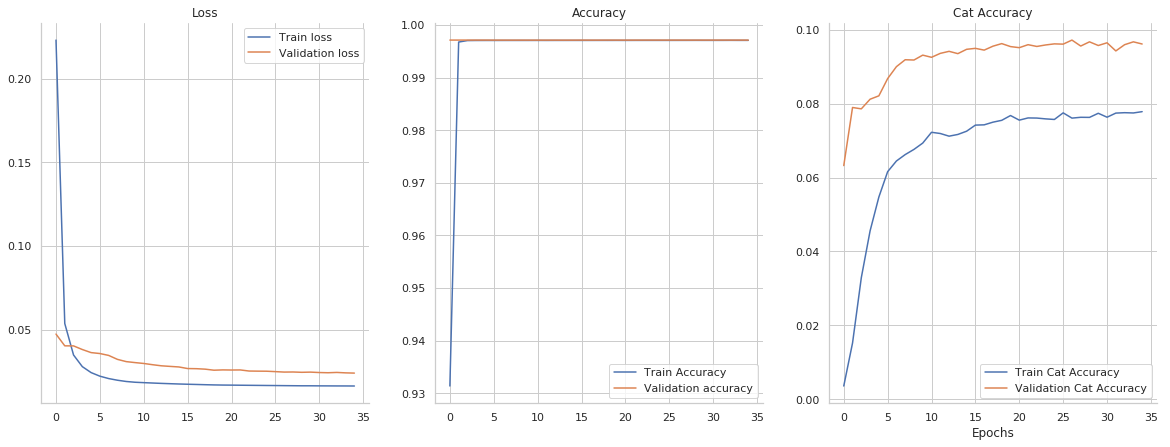

In [8]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

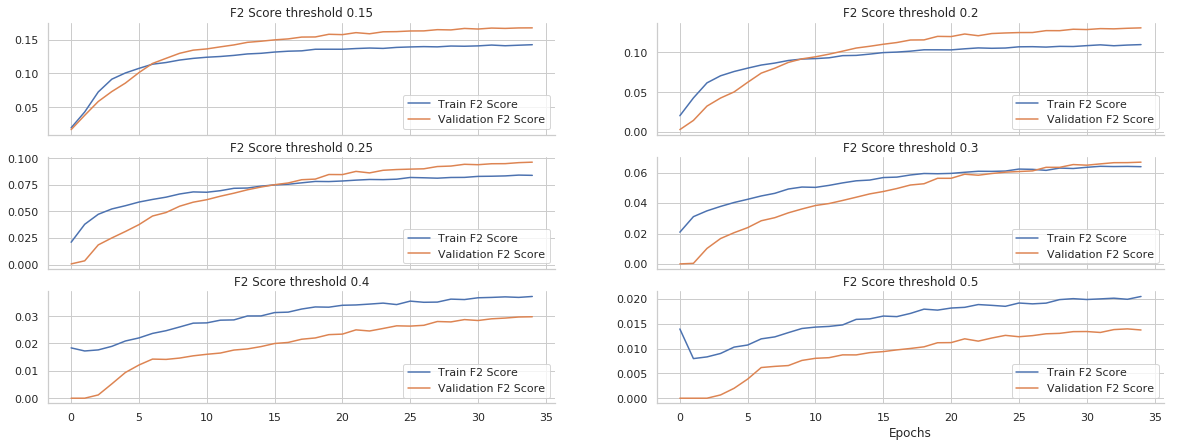

In [9]:
fig, axes = plt.subplots(3, 2, sharex='col', figsize=(20,7))

axes[0][0].plot(history.history['f2_score'], label='Train F2 Score')
axes[0][0].plot(history.history['val_f2_score'], label='Validation F2 Score')
axes[0][0].legend(loc='best')
axes[0][0].set_title('F2 Score threshold 0.15')

axes[0][1].plot(history.history['f2_score_1'], label='Train F2 Score')
axes[0][1].plot(history.history['val_f2_score_1'], label='Validation F2 Score')
axes[0][1].legend(loc='best')
axes[0][1].set_title('F2 Score threshold 0.2')

axes[1][0].plot(history.history['f2_score_2'], label='Train F2 Score')
axes[1][0].plot(history.history['val_f2_score_2'], label='Validation F2 Score')
axes[1][0].legend(loc='best')
axes[1][0].set_title('F2 Score threshold 0.25')

axes[1][1].plot(history.history['f2_score_3'], label='Train F2 Score')
axes[1][1].plot(history.history['val_f2_score_3'], label='Validation F2 Score')
axes[1][1].legend(loc='best')
axes[1][1].set_title('F2 Score threshold 0.3')

axes[2][0].plot(history.history['f2_score_4'], label='Train F2 Score')
axes[2][0].plot(history.history['val_f2_score_4'], label='Validation F2 Score')
axes[2][0].legend(loc='best')
axes[2][0].set_title('F2 Score threshold 0.4')

axes[2][1].plot(history.history['f2_score_5'], label='Train F2 Score')
axes[2][1].plot(history.history['val_f2_score_5'], label='Validation F2 Score')
axes[2][1].legend(loc='best')
axes[2][1].set_title('F2 Score threshold 0.5')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Find best threshold value

In [10]:
best_thr = 0
best_thr_val = history.history['val_f2_score'][-1]
for i in range(1, len(metrics)-2):
    if best_thr_val < history.history['val_f2_score_%s' % i][-1]:
        best_thr_val = history.history['val_f2_score_%s' % i][-1]
        best_thr = i

threshold = thresholds[best_thr]
print('Best threshold is: %s' % threshold)

Best threshold is: 0.15


### Apply model to test set and output predictions

In [11]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

In [12]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

predictions = []
for pred_ar in preds:
    valid = ''
    for idx, pred in enumerate(pred_ar):
        if pred > threshold:
            if len(valid) == 0:
                valid += labels[idx]
            else:
                valid += (' %s' % labels[idx])
    if len(valid) == 0:
        valid = np.argmax(pred_ar)
    predictions.append(valid)

In [13]:
filenames = test_generator.filenames
results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,1059 121 161 304 369 487
1,100fbe75ed8fd887,68
2,101b627524a04f19,1059 813
3,10234480c41284c6,1046 1092 13 147 51 813
4,1023b0e2636dcea8,68
5,1039cd6cf85845c,1092 13 194 405 896
6,103a5b3f83fbe88,1046 1092 13 147 194 51 738 813
7,10413aaae8d6a9a2,1039 1059 121 147 304 369 671 813
8,10423822b93a65ab,1046 13 147 194 369 51 552 586 612 738 776 962
9,1052bf702cb099f7,813
